In [1]:
import drjit as dr
import matplotlib.pyplot as plt
import mitsuba as mi

mi.set_variant("llvm_ad_spectral")

In [2]:
class MyBSDF(mi.BSDF):
    def __init__(self, props):
        mi.BSDF.__init__(self, props)

        self.int_ior = mi.lookup_ior(props, "int_ior", "bk7")

        self.ext_ior = mi.lookup_ior(props, "ext_ior", "air")

        if self.int_ior < 0 or self.ext_ior < 0:
            raise ValueError("The interior and exterior indices of refraction must be positive!")

        self.eta = self.int_ior / self.ext_ior

        self.specular_reflectance = 1.0
        if props.has_property("specular_reflectance"):
            self.specular_reflectance: mi.Texture = props['specular_reflectance']
        self.specular_transmittance = 1.0
        if props.has_property("specular_transmittance"):
            self.specular_transmittance: mi.Texture = props['specular_transmittance']

        # Set the BSDF flags
        reflection_flags   = mi.BSDFFlags.DeltaReflection   | mi.BSDFFlags.FrontSide | mi.BSDFFlags.BackSide
        transmission_flags = mi.BSDFFlags.DeltaTransmission | mi.BSDFFlags.FrontSide | mi.BSDFFlags.BackSide | mi.BSDFFlags.NonSymmetric
        self.m_components  = [reflection_flags, transmission_flags]
        self.m_flags = reflection_flags | transmission_flags

    def sample(self, ctx, si, sample1, sample2, active):
        has_reflection = ctx.is_enabled(mi.BSDFFlags.DeltaReflection, 0)
        has_transmission = ctx.is_enabled(mi.BSDFFlags.DeltaTransmission, 1)

        # Evaluate the Frensel equations for unpolarized illumination
        cos_theta_i = mi.Frame3f.cos_theta(si.wi)

        r_i, cos_theta_t, eta_it, eta_ti = mi.fresnel(cos_theta_i, self.eta)
        t_i = 1.0 - r_i

        bs = mi.BSDFSample3f()
        selected_r = mi.Mask()
        if has_reflection and has_transmission:
            selected_r = (sample1 <= r_i) & active
            bs.pdf = dr.detach(dr.select(selected_r, r_i, t_i))
        else:
            if has_reflection or has_transmission:
                selected_r = has_reflection & active
                bs.pdf = 1.0
            else:
                return bs, 0.0

        selected_t = ~selected_r & active

        bs.sampled_component = dr.select(selected_r, mi.UInt32(0), mi.UInt32(1))
        bs.sampled_type = dr.select(selected_r, mi.UInt32(+mi.BSDFFlags.DeltaReflection),
                                                mi.UInt32(+mi.BSDFFlags.DeltaTransmission))

        bs.wo = dr.select(selected_r,
                          mi.reflect(si.wi),
                          mi.refract(si.wi, cos_theta_t, eta_ti))

        bs.eta = dr.select(selected_r, 1.0, eta_it)

        reflectance = mi.unpolarized_spectrum(1.0)
        transmittance = mi.unpolarized_spectrum(1.0)
        if self.specular_reflectance and self.specular_reflectance != 1.0:
            reflectance = self.specular_reflectance.eval(si, selected_r)
        if self.specular_transmittance and self.specular_reflectance != 1.0:
            transmittance = self.specular_transmittance.eval(si, selected_t)

        value_r = mi.Spectrum(0.0)
        value_t = mi.Spectrum(0.0)

        if has_reflection and has_transmission:
            value_r = mi.Spectrum(1.0)
            value_t = mi.Spectrum(1.0)
        elif has_reflection:
            value_r = mi.Spectrum(r_i)
        elif has_transmission:
            value_t = mi.Spectrum(t_i)

        value_r *= reflectance
        value_t *= transmittance

        # For transmission, radiance must be scaled to account for the solid
        # angle compression that occurs when crossing the interface.
        factor = eta_ti if ctx.mode == mi.TransportMode.Radiance else 1.0
        value_t *= dr.sqr(factor)

        value = dr.select(selected_r, value_r, value_t)

        return bs, value

    def eval(self, ctx, si, wo, active):
        return 0.0

    def pdf(self, ctx, si, wo, active):
        return 0.0

    def eval_pdf(self, ctx, si, wo, active):
        return 0.0, 0.0

    def traverse(self, callback: mi.TraversalCallback):
        callback.put_parameter('eta', self.eta, +mi.ParamFlags.NonDifferentiable)
        if self.specular_reflectance:
            callback.put_object("specular_reflectance", self.specular_reflectance, +mi.ParamFlags.Differentiable)
        if self.specular_transmittance:
            callback.put_object("specular_transmittance", self.specular_transmittance, +mi.ParamFlags.Differentiable)

    def to_string(self):
        return (f'MyBSDF[\n'
                f'    eta={self.eta},\n'
                f']')

In [3]:
mi.register_bsdf("mybsdf", lambda props: MyBSDF(props))

In [4]:
scene = mi.load_file("matpreview/scene.xml")

In [5]:
img = mi.render(scene)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


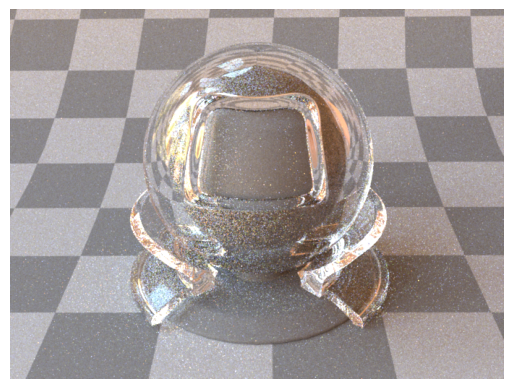

In [6]:
plt.axis("off")
plt.imshow(img ** (1.0 / 2.2)) # approximate sRGB tonemapping